<a href="https://colab.research.google.com/github/jhlee508/handson-ml2-study/blob/master/HoM_Ch3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter3 - 분류 Classification

In [ ]:
import os
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sn
sn.set()

import warnings
warnings.filterwarnings('ignore')

### MNIST

In [ ]:
from tensorflow.keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
X = np.vstack((train_x, test_x))
X = X.reshape([-1, 28*28])

y = np.append(train_y, test_y)

print('X.shape :', X.shape)
print('y.shape :', y.shape)

X.shape : (70000, 784)
y.shape : (70000,)


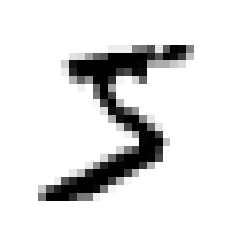

In [ ]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

MNIST 데이터셋을 Train Set과 Test Set을 나누어 보자.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

print('X_train.shape :', X_train.shape)
print('X_test.shape :', X_test.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)

X_train.shape : (60000, 784)
X_test.shape : (10000, 784)
y_train.shape : (60000,)
y_test.shape : (10000,)


## 이진 분류기

In [ ]:
y_train_5 = (y_train == 5)  # 5는 True, 다른 숫자는 False
y_test_5 = (y_test == 5)

In [ ]:
np.where(y_train == 5)

(array([    8,    11,    25, ..., 59928, 59942, 59965]),)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# some_digit = X[35]
sgd_clf.predict([some_digit])

array([ True])

## 성능 측정

### 교차 검증을 사용한 정확도 측정

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9681 , 0.95655, 0.95515])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # sgd_clf 복제
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9681
0.95655
0.95515


In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

### 오차 행렬 (Confusion Matrix)

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53124,  1455],
       [  949,  4472]])

In [ ]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

### 정밀도와 재현율 

#### Precision (정밀도)

In [ ]:
precision = 4472 / (4472 + 1455)
precision

0.754513244474439

In [ ]:
from sklearn.metrics import precision_score, recall_score

# 정밀도 점수
precision_score(y_train_5, y_train_pred)

0.754513244474439

#### Recall (재현율)

In [ ]:
recall = 4472 / (4472 + 949)
recall

0.8249400479616307

In [ ]:
recall_score(y_train_5, y_train_pred)

0.8249400479616307

#### F1 Score

In [ ]:
f1_score_ = 4472 / (4472 + (949 + 1455)/2)
f1_score_

0.7881565033486077

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7881565033486078

### 정밀도/재현율 Trade-Off

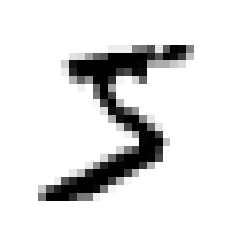

In [ ]:
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [ ]:
# 결정 함수
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3251.81547403])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
# 임계값을 올리면 정밀도는 증가하나 재현율은 감소
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
# 결정 점수 반환
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
y_scores.shape

(60000,)

In [ ]:
y_scores

array([-18922.19789678,  -9437.14784295,  -2464.76484921, ...,
        -7512.63380148, -16501.63029593, -16429.11305816])

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
precisions.shape, recalls.shape, thresholds.shape

((59918,), (59918,), (59917,))

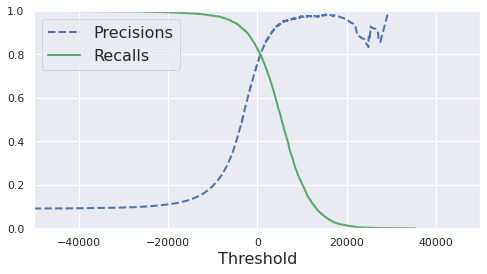

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisions", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recalls", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-50000, 50000])
plt.show()

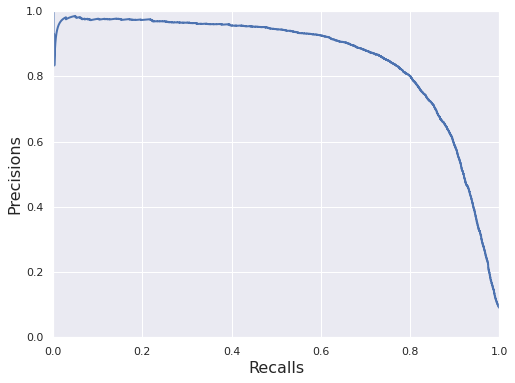

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b", linewidth=2)
    plt.xlabel("Recalls", fontsize=16)
    plt.ylabel("Precisions", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3214.58435004113

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ..., False, False, False])

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.6640841173215274

### ROC 곡선


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

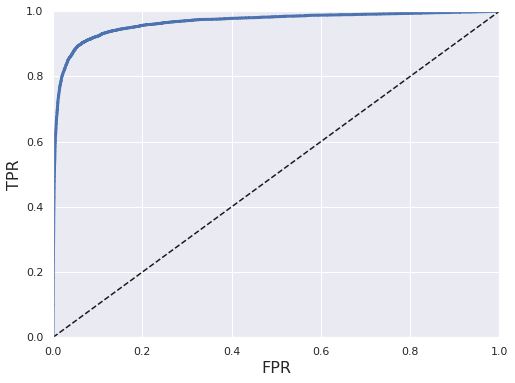

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=3, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9660259463088996

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_probas_forest[:, 1] # 양성 클래스일 확률

array([0.02, 0.04, 0.  , ..., 0.  , 0.05, 0.02])

In [ ]:
y_scores_forest = y_probas_forest[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

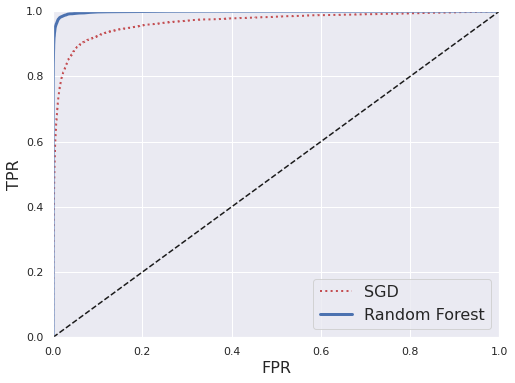

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "r:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983631764491033

In [ ]:
# 랜덤포레스트 : 정밀도
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9890893831305078

In [ ]:
# 랜덤포레스트 : 재현율
recall_score(y_train_5, y_train_pred_forest)

0.8695812580704667

## 다중 분류

In [ ]:
# SGD
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-21615.39389421, -36106.66306547,  -9085.34162979,
          3025.25933537, -36357.90773687,   1925.72172007,
        -19655.38343911, -16914.54767509, -14099.54704496,
        -11911.74666988]])

In [ ]:
np.argmax(some_digit_scores)

3

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=5,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [ ]:
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovo_clf.estimators_)

45

In [ ]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
forest_clf.predict_proba([some_digit])

array([[0.01, 0.  , 0.03, 0.06, 0.  , 0.88, 0.  , 0.01, 0.01, 0.  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8678 , 0.88195, 0.86965])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90425, 0.9031 , 0.8903 ])

## 에러 분석

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   19,    5,   10,   39,   33,    5,  234,    1],
       [   1, 6413,   44,   17,    4,   45,    4,    8,  198,    8],
       [  23,   32, 5249,   88,   71,   20,   62,   39,  366,    8],
       [  27,   20,  115, 5216,    0,  197,   24,   44,  425,   63],
       [   7,   14,   46,   11, 5216,    8,   35,   20,  331,  154],
       [  28,   19,   31,  141,   52, 4466,   78,   18,  523,   65],
       [  27,   16,   50,    2,   39,   87, 5564,    7,  126,    0],
       [  20,   11,   52,   23,   50,   10,    4, 5702,  190,  203],
       [  18,   60,   42,  101,    2,  120,   32,   12, 5425,   39],
       [  22,   21,   29,   62,  123,   35,    1,  170,  361, 5125]])

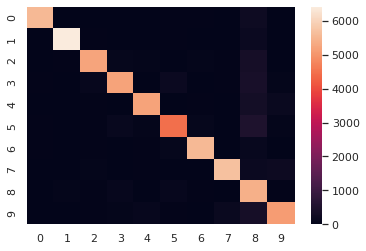

In [ ]:
sn.heatmap(conf_mx);

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

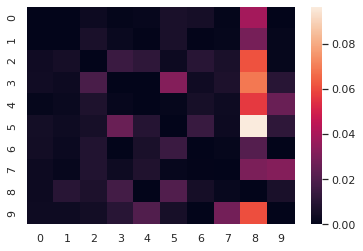

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
sn.heatmap(norm_conf_mx);

In [ ]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

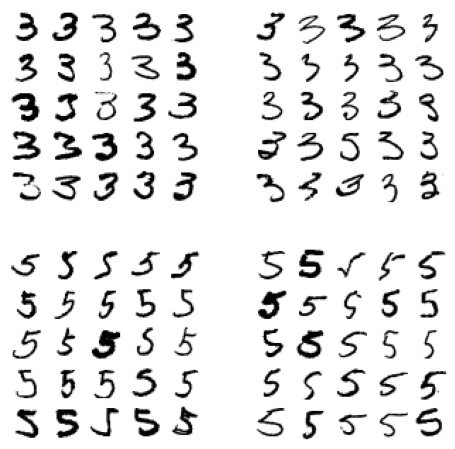

In [ ]:
import matplotlib

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 다중 레이블 분류


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_clf.predict([some_digit])  # == 5

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [ ]:
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

0.9768224011622285


## 다중 출력 분류

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

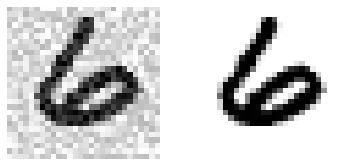

In [ ]:
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

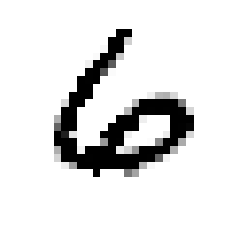

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)